In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/iciar/train/'
test_dir = "data/iciar/test/"

extracted_features_dir = "extracted_features/"
model_name = "iciar_DenseNet121"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/iciar/train/ 0
data/iciar/train/carcinoma 2310
data/iciar/train/non-carcinoma 2310
******************************
data/iciar/test/ 0
data/iciar/test/carcinoma 50
data/iciar/test/non-carcinoma 50


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3466 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3466
nb_validation_samples: 1154

predict_size_train: 109
predict_size_validation: 37
nb_test_samples: 100
predict_size_test: 4

 num_classes: 2


In [9]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [10]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet


In [11]:
input_tensor = Input(shape = input_shape)  
model = DenseNet121(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [12]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [13]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [14]:
# bottleneck_final_model.summary()

In [15]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [16]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [17]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [18]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3466 samples, validate on 1154 samples
Epoch 1/1000
 - 2s - loss: 0.6311 - acc: 0.6694 - val_loss: 0.4585 - val_acc: 0.7972
Epoch 2/1000
 - 0s - loss: 0.4714 - acc: 0.7781 - val_loss: 0.3995 - val_acc: 0.8284
Epoch 3/1000
 - 0s - loss: 0.4058 - acc: 0.8220 - val_loss: 0.3606 - val_acc: 0.8380
Epoch 4/1000
 - 0s - loss: 0.3666 - acc: 0.8364 - val_loss: 0.3405 - val_acc: 0.8553
Epoch 5/1000
 - 0s - loss: 0.3307 - acc: 0.8644 - val_loss: 0.3195 - val_acc: 0.8596
Epoch 6/1000
 - 0s - loss: 0.3104 - acc: 0.8754 - val_loss: 0.2912 - val_acc: 0.8778
Epoch 7/1000
 - 0s - loss: 0.2873 - acc: 0.8860 - val_loss: 0.2767 - val_acc: 0.8856
Epoch 8/1000
 - 0s - loss: 0.2733 - acc: 0.8918 - val_loss: 0.2673 - val_acc: 0.8865
Epoch 9/1000
 - 0s - loss: 0.2557 - acc: 0.9002 - val_loss: 0.2476 - val_acc: 0.9064
Epoch 10/1000
 - 0s - loss: 0.2373 - acc: 0.9080 - val_loss: 0.2370 - val_acc: 0.9073
Epoch 11/1000
 - 0s - loss: 0.2212 - acc: 0.9186 - val_loss: 0.2229 - val_acc: 0.9159
Epoch 12/1000
 

Epoch 96/1000
 - 0s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 0.9861
Epoch 97/1000
 - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9853
Epoch 98/1000
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0400 - val_acc: 0.9844
Epoch 99/1000
 - 0s - loss: 0.0027 - acc: 0.9997 - val_loss: 0.0477 - val_acc: 0.9835
Epoch 100/1000
 - 0s - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0412 - val_acc: 0.9861
Epoch 101/1000
 - 0s - loss: 0.0033 - acc: 0.9994 - val_loss: 0.0426 - val_acc: 0.9861
Epoch 102/1000
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.9835
Epoch 103/1000
 - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0430 - val_acc: 0.9861
Epoch 104/1000
 - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0433 - val_acc: 0.9835
Epoch 105/1000
 - 0s - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0502 - val_acc: 0.9835
Epoch 106/1000
 - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0469 - val_acc: 0.9835
Epoch 107/1000
 - 0s - loss: 0.0023 - acc: 0.99

Epoch 188/1000
 - 0s - loss: 1.6911e-04 - acc: 1.0000 - val_loss: 0.0426 - val_acc: 0.9887
Epoch 189/1000
 - 0s - loss: 1.2468e-04 - acc: 1.0000 - val_loss: 0.0492 - val_acc: 0.9879
Epoch 190/1000
 - 0s - loss: 4.4704e-04 - acc: 0.9997 - val_loss: 0.0516 - val_acc: 0.9861
Epoch 191/1000
 - 0s - loss: 1.3644e-04 - acc: 1.0000 - val_loss: 0.0480 - val_acc: 0.9853
Epoch 192/1000
 - 0s - loss: 8.5566e-05 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 0.9879
Epoch 193/1000
 - 0s - loss: 3.4092e-04 - acc: 0.9997 - val_loss: 0.0618 - val_acc: 0.9861
Epoch 194/1000
 - 0s - loss: 1.7957e-04 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9905
Epoch 195/1000
 - 0s - loss: 2.1800e-04 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9879
Epoch 196/1000
 - 0s - loss: 1.1613e-04 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9870
Epoch 197/1000
 - 0s - loss: 1.5960e-04 - acc: 1.0000 - val_loss: 0.0476 - val_acc: 0.9861
Epoch 198/1000
 - 0s - loss: 8.9488e-05 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9879

 - 0s - loss: 1.1401e-04 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9896
Epoch 279/1000
 - 0s - loss: 6.2754e-05 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9870
Epoch 280/1000
 - 0s - loss: 1.5491e-05 - acc: 1.0000 - val_loss: 0.0415 - val_acc: 0.9905
Epoch 281/1000
 - 0s - loss: 1.1759e-05 - acc: 1.0000 - val_loss: 0.0491 - val_acc: 0.9896
Epoch 282/1000
 - 0s - loss: 3.5627e-05 - acc: 1.0000 - val_loss: 0.0532 - val_acc: 0.9879
Epoch 283/1000
 - 0s - loss: 2.7780e-05 - acc: 1.0000 - val_loss: 0.0528 - val_acc: 0.9879
Epoch 284/1000
 - 0s - loss: 2.8964e-05 - acc: 1.0000 - val_loss: 0.0578 - val_acc: 0.9887
Epoch 285/1000
 - 0s - loss: 5.8866e-05 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9896
Epoch 286/1000
 - 0s - loss: 1.2572e-04 - acc: 1.0000 - val_loss: 0.0517 - val_acc: 0.9879
Epoch 287/1000
 - 0s - loss: 3.6371e-05 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9879
Epoch 288/1000
 - 0s - loss: 1.4328e-05 - acc: 1.0000 - val_loss: 0.0474 - val_acc: 0.9905
Epoch 289/1000

Epoch 369/1000
 - 0s - loss: 6.9368e-06 - acc: 1.0000 - val_loss: 0.0607 - val_acc: 0.9879
Epoch 370/1000
 - 0s - loss: 5.7938e-06 - acc: 1.0000 - val_loss: 0.0505 - val_acc: 0.9913
Epoch 371/1000
 - 0s - loss: 7.3282e-05 - acc: 1.0000 - val_loss: 0.0586 - val_acc: 0.9896
Epoch 372/1000
 - 0s - loss: 1.8679e-06 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9879
Epoch 373/1000
 - 0s - loss: 5.2657e-06 - acc: 1.0000 - val_loss: 0.0633 - val_acc: 0.9879
Epoch 374/1000
 - 0s - loss: 9.3020e-06 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9905
Epoch 375/1000
 - 0s - loss: 5.4924e-06 - acc: 1.0000 - val_loss: 0.0469 - val_acc: 0.9905
Epoch 376/1000
 - 0s - loss: 7.7755e-05 - acc: 1.0000 - val_loss: 0.0603 - val_acc: 0.9870
Epoch 377/1000
 - 0s - loss: 6.7800e-06 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9887
Epoch 378/1000
 - 0s - loss: 9.0790e-06 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9913
Epoch 379/1000
 - 0s - loss: 9.5143e-06 - acc: 1.0000 - val_loss: 0.0433 - val_acc: 0.9913

 - 0s - loss: 4.1542e-07 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9905
Epoch 460/1000
 - 0s - loss: 1.6354e-06 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9896
Epoch 461/1000
 - 0s - loss: 1.7343e-06 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 0.9896
Epoch 462/1000
 - 0s - loss: 2.0816e-06 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9913
Epoch 463/1000
 - 0s - loss: 2.6736e-06 - acc: 1.0000 - val_loss: 0.0676 - val_acc: 0.9879
Epoch 464/1000
 - 0s - loss: 2.3281e-06 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9887
Epoch 465/1000
 - 0s - loss: 1.2732e-06 - acc: 1.0000 - val_loss: 0.0669 - val_acc: 0.9896
Epoch 466/1000
 - 0s - loss: 3.1467e-06 - acc: 1.0000 - val_loss: 0.0484 - val_acc: 0.9913
Epoch 467/1000
 - 0s - loss: 3.2437e-06 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 0.9913
Epoch 468/1000
 - 0s - loss: 1.2748e-05 - acc: 1.0000 - val_loss: 0.0492 - val_acc: 0.9913
Epoch 469/1000
 - 0s - loss: 6.8866e-07 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9905
Epoch 470/1000

Epoch 550/1000
 - 0s - loss: 3.5997e-07 - acc: 1.0000 - val_loss: 0.0583 - val_acc: 0.9896
Epoch 551/1000
 - 0s - loss: 2.3638e-07 - acc: 1.0000 - val_loss: 0.0581 - val_acc: 0.9896
Epoch 552/1000
 - 0s - loss: 5.1045e-07 - acc: 1.0000 - val_loss: 0.0564 - val_acc: 0.9905
Epoch 553/1000
 - 0s - loss: 9.6672e-07 - acc: 1.0000 - val_loss: 0.0561 - val_acc: 0.9913
Epoch 554/1000
 - 0s - loss: 3.0082e-06 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9896
Epoch 555/1000
 - 0s - loss: 2.4993e-04 - acc: 0.9997 - val_loss: 0.0600 - val_acc: 0.9887
Epoch 556/1000
 - 0s - loss: 3.5832e-06 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9887
Epoch 557/1000
 - 0s - loss: 7.1351e-07 - acc: 1.0000 - val_loss: 0.0693 - val_acc: 0.9870
Epoch 558/1000
 - 0s - loss: 6.6340e-07 - acc: 1.0000 - val_loss: 0.0695 - val_acc: 0.9879
Epoch 559/1000
 - 0s - loss: 1.1158e-06 - acc: 1.0000 - val_loss: 0.0565 - val_acc: 0.9905
Epoch 560/1000
 - 0s - loss: 1.3416e-06 - acc: 1.0000 - val_loss: 0.0494 - val_acc: 0.9913

 - 0s - loss: 7.9581e-06 - acc: 1.0000 - val_loss: 0.0511 - val_acc: 0.9913
Epoch 641/1000
 - 0s - loss: 2.6889e-07 - acc: 1.0000 - val_loss: 0.0516 - val_acc: 0.9913
Epoch 642/1000
 - 0s - loss: 3.9205e-07 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9896
Epoch 643/1000
 - 0s - loss: 3.7836e-06 - acc: 1.0000 - val_loss: 0.0593 - val_acc: 0.9896
Epoch 644/1000
 - 0s - loss: 2.7001e-06 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9913
Epoch 645/1000
 - 0s - loss: 2.8464e-07 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.9913
Epoch 646/1000
 - 0s - loss: 3.0449e-06 - acc: 1.0000 - val_loss: 0.0525 - val_acc: 0.9913
Epoch 647/1000
 - 0s - loss: 5.7139e-06 - acc: 1.0000 - val_loss: 0.0511 - val_acc: 0.9922
Epoch 648/1000
 - 0s - loss: 2.8367e-07 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9879
Epoch 649/1000
 - 0s - loss: 6.8484e-07 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9905
Epoch 650/1000
 - 0s - loss: 1.8600e-07 - acc: 1.0000 - val_loss: 0.0651 - val_acc: 0.9879
Epoch 651/1000

Epoch 731/1000
 - 0s - loss: 1.6743e-07 - acc: 1.0000 - val_loss: 0.0532 - val_acc: 0.9905
Epoch 732/1000
 - 0s - loss: 2.2517e-07 - acc: 1.0000 - val_loss: 0.0593 - val_acc: 0.9896
Epoch 733/1000
 - 0s - loss: 1.9290e-07 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 0.9879
Epoch 734/1000
 - 0s - loss: 1.8932e-07 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9913
Epoch 735/1000
 - 0s - loss: 1.5761e-07 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9896
Epoch 736/1000
 - 0s - loss: 8.0662e-07 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9905
Epoch 737/1000
 - 0s - loss: 3.1273e-07 - acc: 1.0000 - val_loss: 0.0690 - val_acc: 0.9879
Epoch 738/1000
 - 0s - loss: 2.4371e-07 - acc: 1.0000 - val_loss: 0.0595 - val_acc: 0.9896
Epoch 739/1000
 - 0s - loss: 1.4268e-07 - acc: 1.0000 - val_loss: 0.0543 - val_acc: 0.9896
Epoch 740/1000
 - 0s - loss: 2.4869e-07 - acc: 1.0000 - val_loss: 0.0581 - val_acc: 0.9887
Epoch 741/1000
 - 0s - loss: 4.9512e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9905

 - 0s - loss: 2.3502e-07 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.9913
Epoch 822/1000
 - 0s - loss: 6.8579e-07 - acc: 1.0000 - val_loss: 0.0589 - val_acc: 0.9905
Epoch 823/1000
 - 0s - loss: 2.6555e-07 - acc: 1.0000 - val_loss: 0.0492 - val_acc: 0.9922
Epoch 824/1000
 - 0s - loss: 1.4079e-07 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9905
Epoch 825/1000
 - 0s - loss: 2.0820e-06 - acc: 1.0000 - val_loss: 0.0497 - val_acc: 0.9913
Epoch 826/1000
 - 0s - loss: 8.3183e-07 - acc: 1.0000 - val_loss: 0.0472 - val_acc: 0.9931
Epoch 827/1000
 - 0s - loss: 1.7900e-07 - acc: 1.0000 - val_loss: 0.0782 - val_acc: 0.9861
Epoch 828/1000
 - 0s - loss: 3.8391e-06 - acc: 1.0000 - val_loss: 0.0505 - val_acc: 0.9922
Epoch 829/1000
 - 0s - loss: 2.1472e-07 - acc: 1.0000 - val_loss: 0.0691 - val_acc: 0.9896
Epoch 830/1000
 - 0s - loss: 1.9885e-07 - acc: 1.0000 - val_loss: 0.0494 - val_acc: 0.9922
Epoch 831/1000
 - 0s - loss: 1.3262e-07 - acc: 1.0000 - val_loss: 0.0580 - val_acc: 0.9905
Epoch 832/1000

Epoch 912/1000
 - 0s - loss: 1.5015e-07 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9896
Epoch 913/1000
 - 0s - loss: 1.5436e-06 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9913
Epoch 914/1000
 - 0s - loss: 1.3732e-07 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9922
Epoch 915/1000
 - 0s - loss: 7.0326e-07 - acc: 1.0000 - val_loss: 0.0632 - val_acc: 0.9913
Epoch 916/1000
 - 0s - loss: 2.3485e-07 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 0.9939
Epoch 917/1000
 - 0s - loss: 1.3840e-07 - acc: 1.0000 - val_loss: 0.0501 - val_acc: 0.9922
Epoch 918/1000
 - 0s - loss: 4.2427e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9913
Epoch 919/1000
 - 0s - loss: 1.3496e-07 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9913
Epoch 920/1000
 - 0s - loss: 1.4310e-07 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9896
Epoch 921/1000
 - 0s - loss: 1.5639e-07 - acc: 1.0000 - val_loss: 0.0555 - val_acc: 0.9896
Epoch 922/1000
 - 0s - loss: 1.3923e-07 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9922

In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.89


Confusion Matrix
[[47  3]
 [ 8 42]]


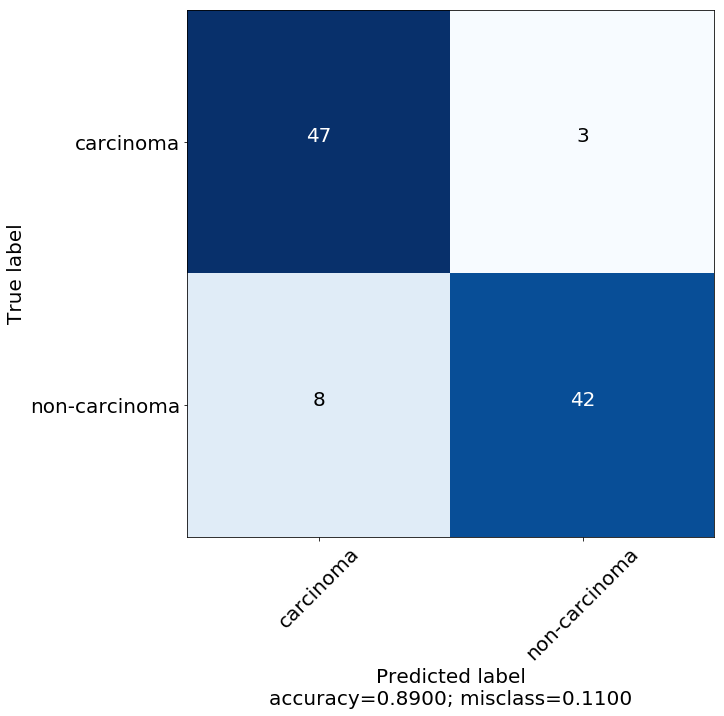

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[47  3]
 [ 8 42]]
               precision    recall  f1-score   support

    carcinoma       0.85      0.94      0.90        50
non-carcinoma       0.93      0.84      0.88        50

  avg / total       0.89      0.89      0.89       100



In [22]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  85.45454545454545
Specificity :  93.33333333333333


In [23]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8939393939393939


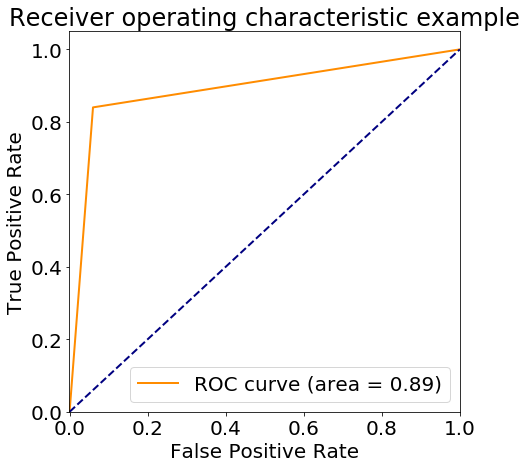

In [24]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [25]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

100/100 [==============================] - 0s 60us/step


In [26]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

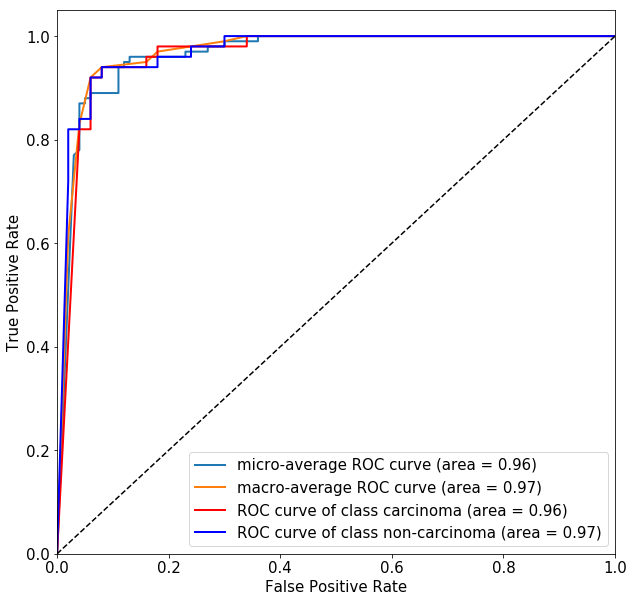

In [28]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [29]:
tn, fp, fn, tp = cm.ravel()

In [30]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.89
Precision: 0.9333333333333333
Recall: 0.84
tp: 42
fp: 3
tn: 47
fn: 8


In [31]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8842105263157894


In [32]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8842105263157894


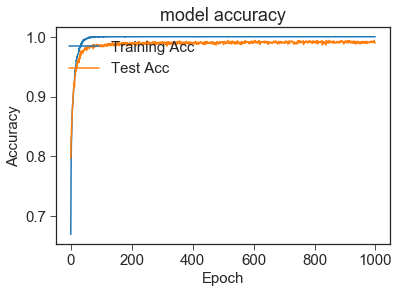

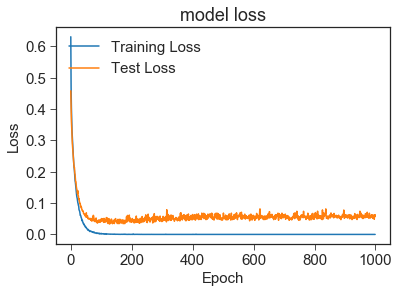

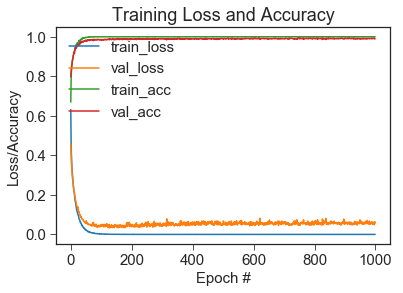

In [33]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")